In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt

data = pd.read_csv("ARIMA预测.csv")

In [2]:
a1 = 0.98
a2 = 0.99


##### 马科维兹优化
def E(w, t=0):
    return a1 * (data['Bitcoin_pre'][t + 1] / data['Bitcoin'][t]) * w[0] + a2 * (
                data['Gold_pre'][t + 1] / data['Gold'][t]) * w[1] - 1.02 * w[0] - 1.01 * w[1]


def D(w, t=0):
    return data['predict_bitcoin_volatility'][t + 1] * w[0] * w[0] + data['predict_gold_volatility'][t + 1] * w[1] * w[
        1] + 2 * 0.645 * data['predict_both_volatility'][t + 1] * w[0] * w[1]


def func(w, t=0):
    return -E(w, t) + 10 * D(w, t)

In [3]:
##### 最大夏普优化

def sharp(w, t=0):
    return -((E(w, t) / (w[0] + w[1]) - 0.04) / np.sqrt(D(w, t)))

In [4]:
##### 风险平价优化

def risk(w, t=0):
    return abs(
        data['predict_bitcoin_volatility'][t + 1] * w[0] * w[0] - data['predict_gold_volatility'][t + 1] * w[1] * w[
            1]) / D(w, t)

In [5]:
Er1 = []
Er2 = []
Er3 = []
strategy = []
for t in range(data.shape[0] - 1):
    cons = ({'type': 'ineq',
             'fun': lambda w: E(w, t) + 1},
            {'type': 'ineq',
             'fun': lambda w: -w[0] - w[1] + 1})
    res1 = opt.minimize(func, [0.1, 0.1], args=(t,), bounds=[(0.1, 1), (0.1, 1)],
                        constraints=cons, method='SLSQP', options={'disp': False})
    res2 = opt.minimize(sharp, [0.1, 0.1], args=(t,), bounds=[(0, 1), (0, 1)],
                        constraints=cons, method='SLSQP', options={'disp': False})
    res3 = opt.minimize(risk, [0.1, 0.1], args=(t,), bounds=[(0, 1), (0, 1)],
                        constraints=cons, method='SLSQP', options={'disp': False})
    w1 = res1.x
    w2 = res2.x
    w3 = res3.x
    strategy.append(w3)
    e1 = a1 * (data['Bitcoin'][t + 1] / data['Bitcoin'][t]) * w1[0] + a2 * (data['Gold'][t + 1] / data['Gold'][t]) * w1[
        1] - 1.02 * w1[0] - 1.01 * w1[1]
    Er1.append(-e1)
    e2 = a1 * (data['Bitcoin'][t + 1] / data['Bitcoin'][t]) * w2[0] + a2 * (data['Gold'][t + 1] / data['Gold'][t]) * w2[
        1] - 1.02 * w2[0] - 1.01 * w2[1]
    Er2.append(-e2)
    e3 = a1 * (data['Bitcoin'][t + 1] / data['Bitcoin'][t]) * w3[0] + a2 * (data['Gold'][t + 1] / data['Gold'][t]) * w3[
        1] - 1.02 * w3[0] - 1.01 * w3[1]
    Er3.append(-e3)

e:\anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [6]:
ler1 = [1]
ler2 = [1]
ler3 = [1]
for i in range(len(Er1)):
    s1 = 1
    s2 = 1
    s3 = 1
    for j in range(i):
        s1 *= 0.9972 + Er1[j]
        s2 *= 0.9679 + Er2[j]
        s3 *= 0.9829 + Er3[j]

    ler1.append(s1)
    ler2.append(s2)
    ler3.append(s3)

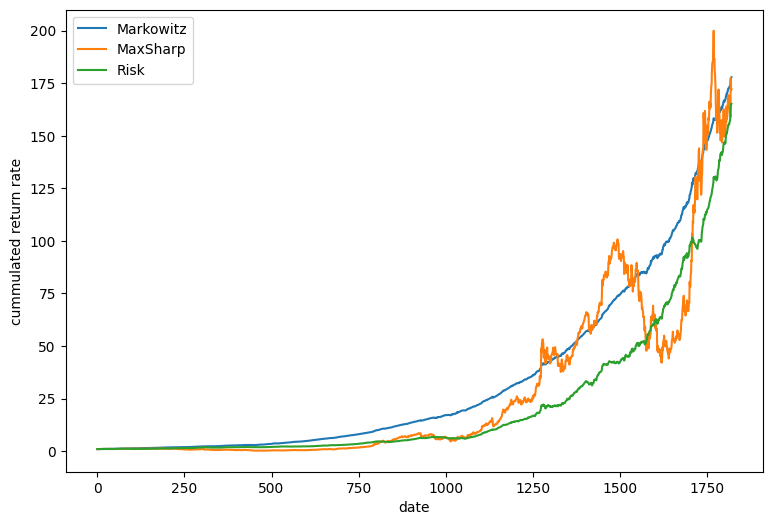

平均收益率：
Markowitz    34.104421
MaxSharp     27.930497
Risk         21.996698
dtype: float64
年化波动率：
Markowitz    29590.974004
MaxSharp     27836.907355
Risk         18438.618474
dtype: float64
平均夏普比率：
Markowitz    0.018274
MaxSharp     0.015905
Risk         0.018903
dtype: float64
胜率：
0.832967032967033 0.6082417582417582 0.65
胜负比：
5.003300330033003 1.5547752808988764 1.860062893081761
盈亏比：
-6.356905176849902 -1.2809324182524067 -3.576593700144947


In [7]:
fig = plt.figure(figsize=(9, 6))
plt.plot(ler1)
plt.plot(ler2)
plt.plot(ler3)
plt.legend(['Markowitz', 'MaxSharp', 'Risk'])
plt.xlabel("date")
plt.ylabel("cummulated return rate")
plt.show()

df = pd.DataFrame({'Markowitz': ler1, 'MaxSharp': ler2, 'Risk': ler3})
ddf = df.diff().dropna()
print("平均收益率：")
print(df.mean())
print("年化波动率：")
print(df.var() * np.sqrt(252))
print("平均夏普比率：")
print((df.mean() - 0.04) / df.var())
print("胜率：")
print(len(ddf[ddf['Markowitz'] > 0]['Markowitz']) / len(ddf), len(ddf[ddf['MaxSharp'] > 0]['MaxSharp']) / len(ddf),
      len(ddf[ddf['Risk'] > 0]['Risk']) / len(ddf))
print("胜负比：")
print(len(ddf[ddf['Markowitz'] > 0]['Markowitz']) / len(ddf[ddf['Markowitz'] < 0]['Markowitz']),
      len(ddf[ddf['MaxSharp'] > 0]['MaxSharp']) / len(ddf[ddf['MaxSharp'] < 0]['MaxSharp']),
      len(ddf[ddf['Risk'] > 0]['Risk']) / len(ddf[ddf['Risk'] < 0]['Risk']))
print("盈亏比：")
print(sum(ddf[ddf['Markowitz'] > 0]['Markowitz']) / sum(ddf[ddf['Markowitz'] < 0]['Markowitz']),
      sum(ddf[ddf['MaxSharp'] > 0]['MaxSharp']) / sum(ddf[ddf['MaxSharp'] < 0]['MaxSharp']),
      sum(ddf[ddf['Risk'] > 0]['Risk']) / sum(ddf[ddf['Risk'] < 0]['Risk']))

